# Imports

In [1]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 8.4 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
from sklearn.metrics import mean_absolute_percentage_error
from catboost import CatBoostRegressor

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
! git clone https://github.com/atahanoezer/Wind.git

Cloning into 'Wind'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 24 (delta 9), reused 10 (delta 4), pack-reused 0
Unpacking objects: 100% (24/24), 931.26 KiB | 3.80 MiB/s, done.


In [5]:
from Wind.dataset import Dataset
from Wind.utils import score_function
from Wind.model import *

In [6]:
import warnings
warnings.filterwarnings('ignore') # to avoid catboost and pd warnings

# Data Preprocess

In [7]:
uebb = '/content/drive/MyDrive/Copy of UEBB_v1.nc'
ds = xr.open_dataset(uebb)
df = ds.to_dataframe()
df = df.reset_index()
df['Time']=pd.to_datetime(df['Time'])
df = df.set_index('Time')

In [8]:
test_time = pd.to_datetime('2014-05-18 18:50:00')
df_test = df[df.index >= test_time]
test_split = len(df_test)/len(df)

Following fields are observed via pandas profiling, reports can be generated by running the profiler function in utils.py

In [9]:
high_empty_fields = ['wind_direction_std','air_temperature','relative_humidity', 'UST','UST_flag', 'HS','HS_flag', 'TKE',
                     'LMO','ws_w_corrected'] #
missing_fields = ['wind_speed','wind_direction','wind_speed_std','wind_speed_max','wind_speed_min',
                         'wind_speed_cube','air_pressure','logger_temperature', 'battery_V','ws_u','ws_v','ws_w',
                         'tilt_X','tilt_Y','tilt_X_std','tilt_Y_std','wind_speed_nacelle','wind_speed_nacelle_max',
                         'wind_speed_nacelle_min','rotor_rpm','rotor_rpm_max','rotor_rpm_min','active_power_total',
                         'active_power_total_max','active_power_total_min','act_position','air_density']

In [19]:
roll_window = 4
dataset = Dataset(df)
dataset.fill_nan(missing_fields)
dataset.drop_nan(high_empty_fields)
dataset.add_seasonal_feat(dataset.df, dataset.df.index)
dataset.sample(200) # converting data to 10minute format
dataset.apply_rolling_window(dataset.df,'wind_speed', roll_window,np.mean)
dataset.apply_rolling_window(dataset.df,'logger_temperature', roll_window,np.mean)
dataset.apply_rolling_window(dataset.df,'battery_V' , roll_window,np.mean)

# Modelling



## Next Step



In [20]:
window = 48
horizon =1
train_x,val_x, test_x, train_y,val_y, test_y,columns =dataset.create_dataset(dataset.df,
                                                                     window, horizon,test_split = test_split)

In [21]:
model = Model('cb',{'thread_count':-1,'task_type':"GPU"})
model.train(train_x, train_y, val_x, val_y)

Learning rate set to 0.087936
0:	learn: 204.3770348	test: 271.1475032	best: 271.1475032 (0)	total: 25.7ms	remaining: 25.7s
500:	learn: 6.5959256	test: 6.7706893	best: 6.7706893 (500)	total: 7.14s	remaining: 7.12s
999:	learn: 5.8880091	test: 6.0553931	best: 6.0549981 (993)	total: 16.2s	remaining: 0us
bestTest = 6.054998137
bestIteration = 993
Shrink model to first 994 iterations.


                 MAE      RMSE        R2
Validation  4.260291  6.054994  0.998319
Test        5.342461  8.196112  0.998466


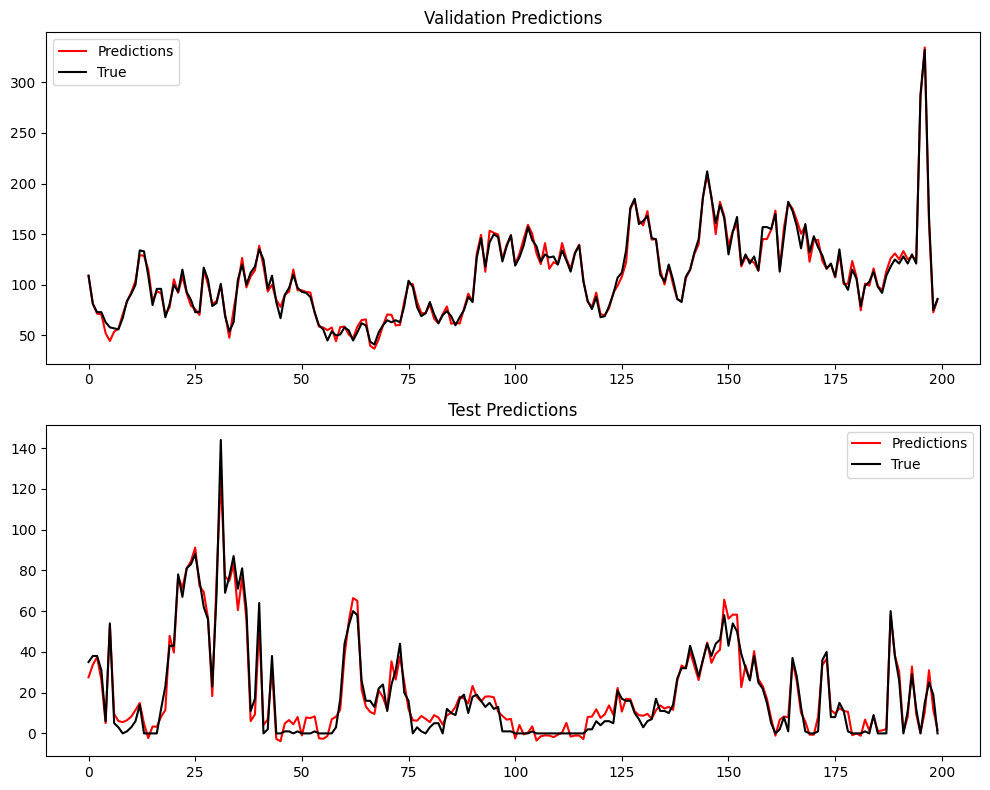

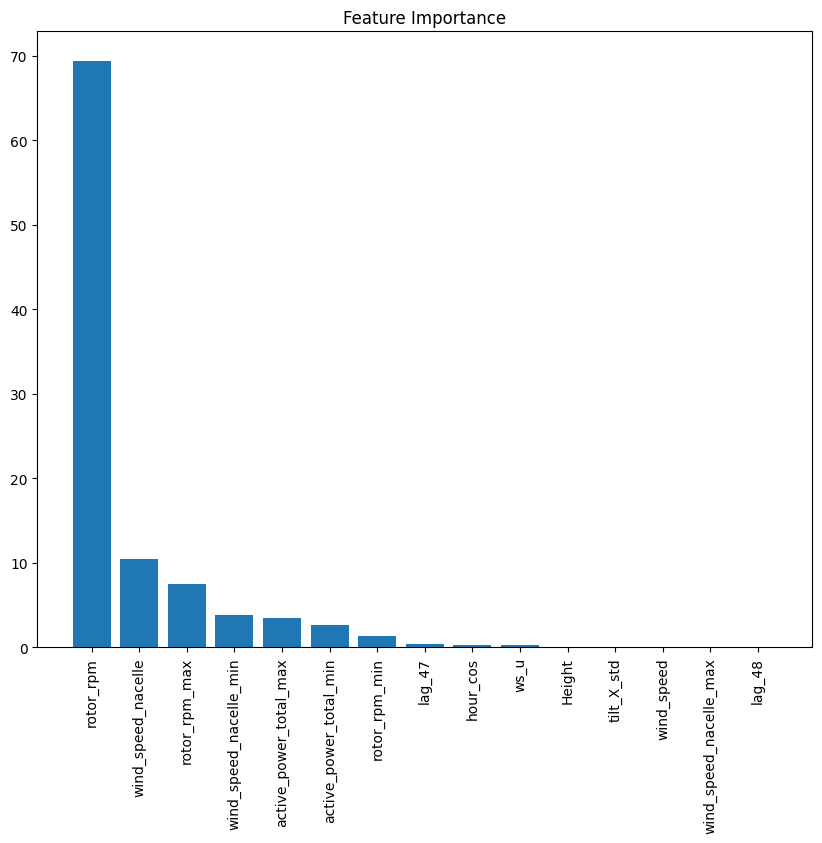

In [22]:
next_step_os,_=model.model_summarizer(val_x, val_y, test_x, test_y, plots=True,
plot_steps=200, feat_importance=True, feat_steps=15,feat_names=columns)



## Next Hour One Shot



In [23]:
window = 48
horizon = 6
train_x,val_x, test_x, train_y,val_y, test_y, columns =dataset.create_dataset(dataset.df,
                                                                     window, horizon,test_split = test_split)

In [24]:
model = Model('cb',{'thread_count':-1,'task_type':"GPU"})
model.train(train_x, train_y[:,-1], val_x, val_y[:,-1],multioutput=False)

Learning rate set to 0.087934
0:	learn: 210.5480085	test: 277.7184944	best: 277.7184944 (0)	total: 29.1ms	remaining: 29.1s
500:	learn: 90.3594169	test: 92.0643981	best: 89.3357581 (232)	total: 8.18s	remaining: 8.15s
999:	learn: 83.0426659	test: 95.6955698	best: 89.3357581 (232)	total: 17.4s	remaining: 0us
bestTest = 89.33575811
bestIteration = 232
Shrink model to first 233 iterations.


                  MAE        RMSE        R2
Validation  64.572209   89.335759  0.634118
Test        83.309166  113.498583  0.705722


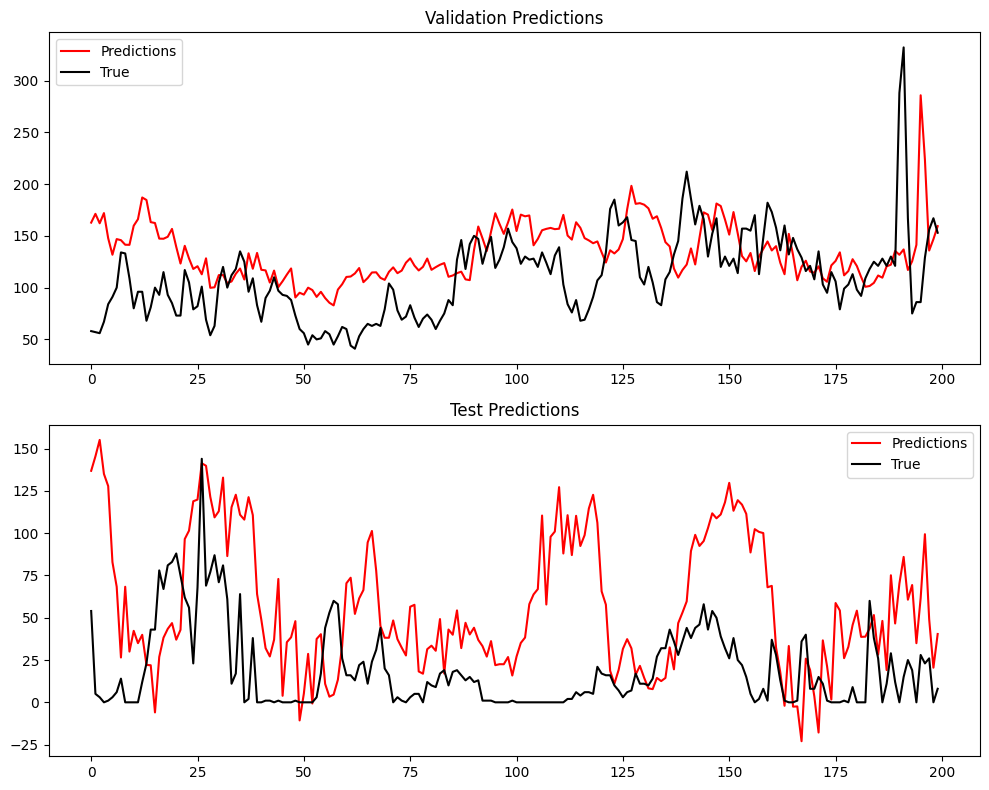

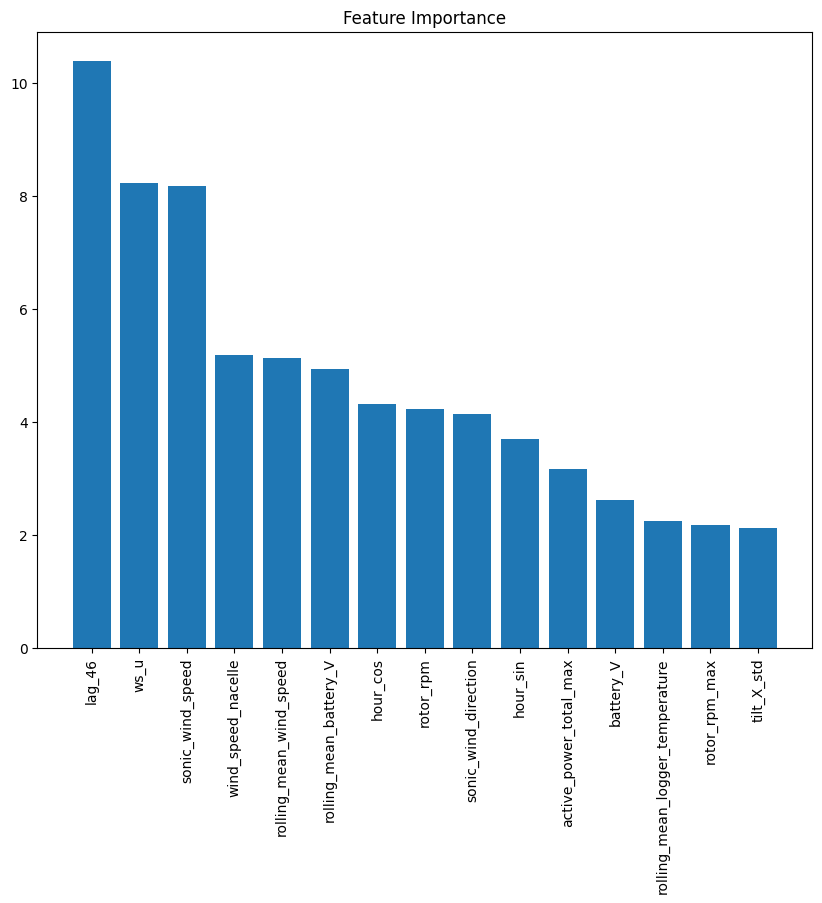

In [25]:
next_hour_os,_=model.model_summarizer(val_x, val_y[:,-1], test_x, test_y[:,-1], plots=True,
plot_steps=200, feat_importance=True, feat_steps=15,feat_names= columns)

## Next Hour Recursive

In [27]:
window = 48
horizon = 6
train_x,val_x, test_x, train_y,val_y, test_y,columns =dataset.create_dataset(dataset.df,
                                                                     window, horizon,test_split = test_split,univariate= True)

In [28]:
model = Model('cb',{'thread_count':-1,'task_type':"GPU"},prediction_type = 'recursive')
model.train(train_x, train_y[:,0], val_x, val_y[:,0],multioutput=False)

Learning rate set to 0.087934
0:	learn: 207.2554720	test: 274.9130623	best: 274.9130623 (0)	total: 21.4ms	remaining: 21.4s
500:	learn: 68.5563491	test: 57.0613392	best: 57.0133359 (392)	total: 5.96s	remaining: 5.93s
999:	learn: 64.6488878	test: 56.9539820	best: 56.9089263 (812)	total: 14s	remaining: 0us
bestTest = 56.9089263
bestIteration = 812
Shrink model to first 813 iterations.


                  MAE       RMSE        R2
Validation  48.971024  69.233644  0.780203
Test        66.936768  92.827993  0.803198


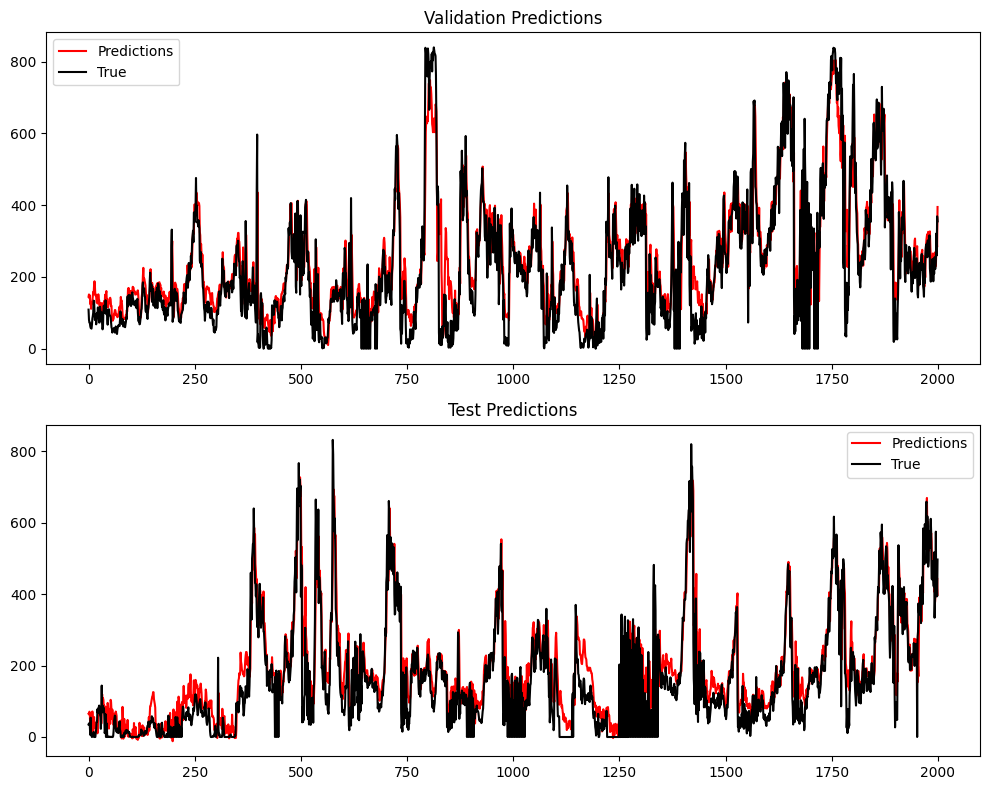

In [29]:
next_hour_rec,_=model.model_summarizer(val_x, val_y[:,0], test_x, test_y[:,0], plots=True,
plot_steps=2000, feat_importance=False, feat_steps=15,feat_names= columns,horizon =6)



## Next Day One Shot



In [34]:
window = 144
horizon = 144
train_x,val_x, test_x, train_y,val_y, test_y,columns =dataset.create_dataset(dataset.df,
                                                                     window, horizon,test_split= test_split)

In [35]:
model = Model('cb',{'thread_count':-1,'task_type':"GPU"})
model.train(train_x, train_y[:,-1], val_x, val_y[:,-1], multioutput= False)

Learning rate set to 0.087845
0:	learn: 215.8844813	test: 282.9376709	best: 282.9376709 (0)	total: 96.9ms	remaining: 1m 36s
500:	learn: 113.1420283	test: 195.5512375	best: 183.8657502 (76)	total: 13.6s	remaining: 13.5s
999:	learn: 96.2682319	test: 199.8221808	best: 183.8657502 (76)	total: 25.2s	remaining: 0us
bestTest = 183.8657502
bestIteration = 76
Shrink model to first 77 iterations.


                   MAE        RMSE        R2
Validation  156.151351  183.865747 -0.530701
Test        160.125895  191.788463  0.152220


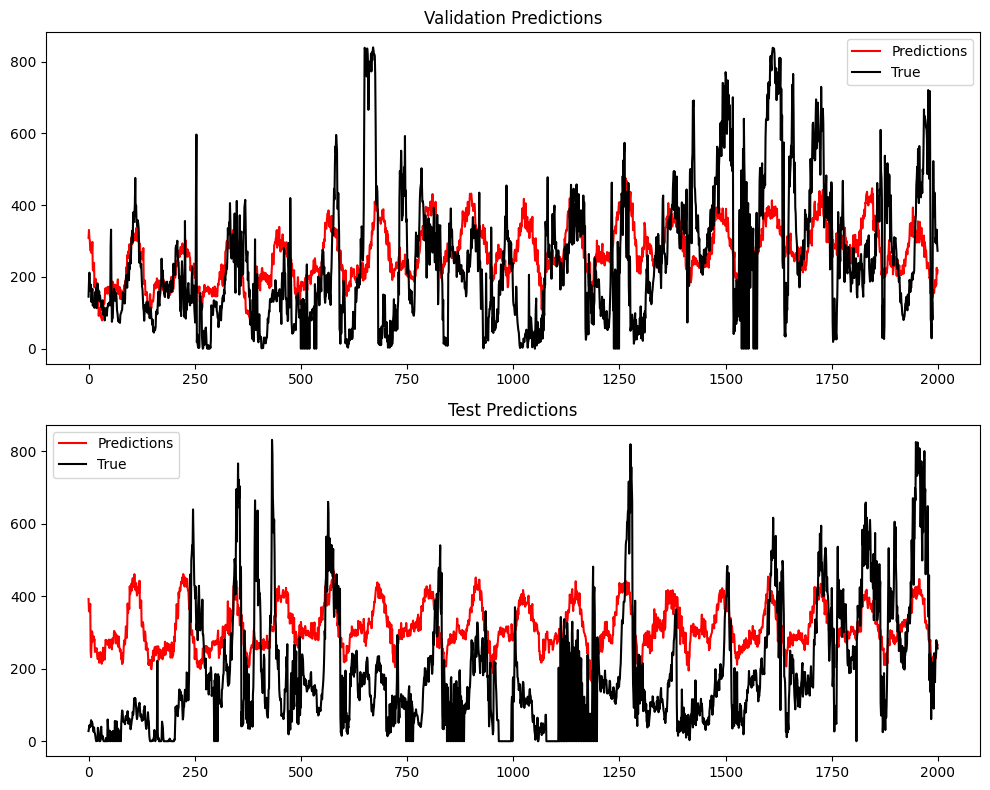

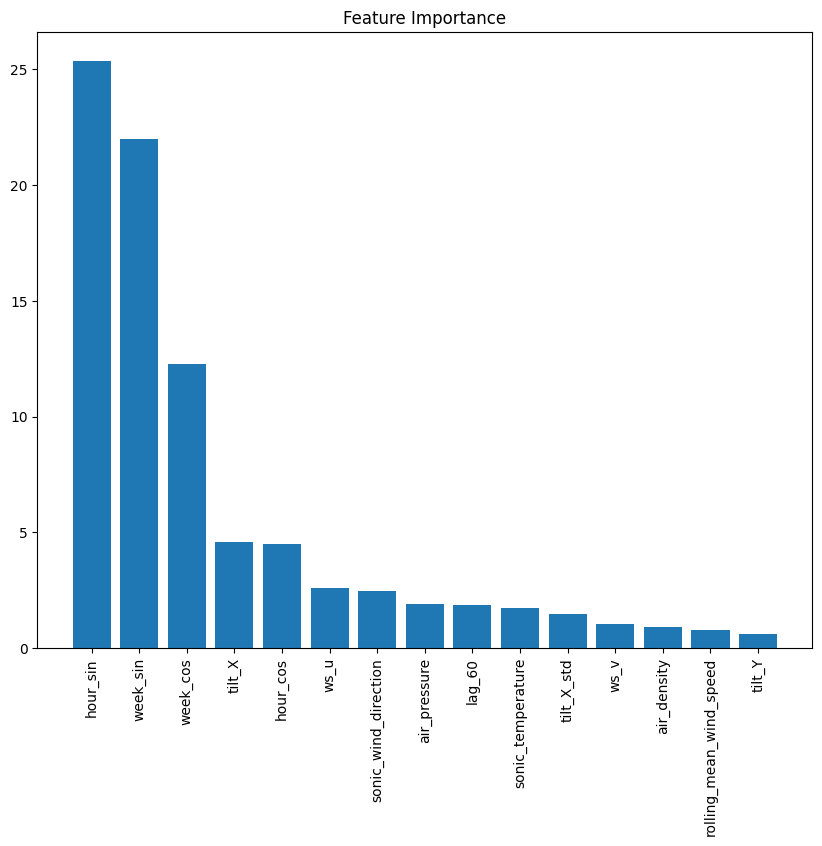

In [36]:
next_day_os,_=model.model_summarizer(val_x, val_y[:,-1], test_x, test_y[:,-1], plots=True,
plot_steps=2000, feat_importance=True, feat_steps=15,feat_names= columns)

## Next Day Recursive

In [38]:
window = 144
horizon = 144
train_x,val_x, test_x, train_y,val_y, test_y,columns =dataset.create_dataset(dataset.df,
                                                                     window, horizon,test_split= test_split,univariate=True)

In [39]:
model = Model('cb',{'thread_count':-1,'task_type':"GPU"},prediction_type = 'recursive')
model.train(train_x, train_y[:,0], val_x, val_y[:,0], multioutput= False)

Learning rate set to 0.087845
0:	learn: 207.4428882	test: 273.9411386	best: 273.9411386 (0)	total: 32.1ms	remaining: 32.1s
500:	learn: 65.8242337	test: 57.5902725	best: 57.2384129 (226)	total: 11s	remaining: 10.9s
999:	learn: 60.8707450	test: 57.9123314	best: 57.2384129 (226)	total: 19.9s	remaining: 0us
bestTest = 57.23841285
bestIteration = 226
Shrink model to first 227 iterations.


                   MAE        RMSE        R2
Validation   74.141135  100.526795  0.539371
Test        125.653167  160.811646  0.411974


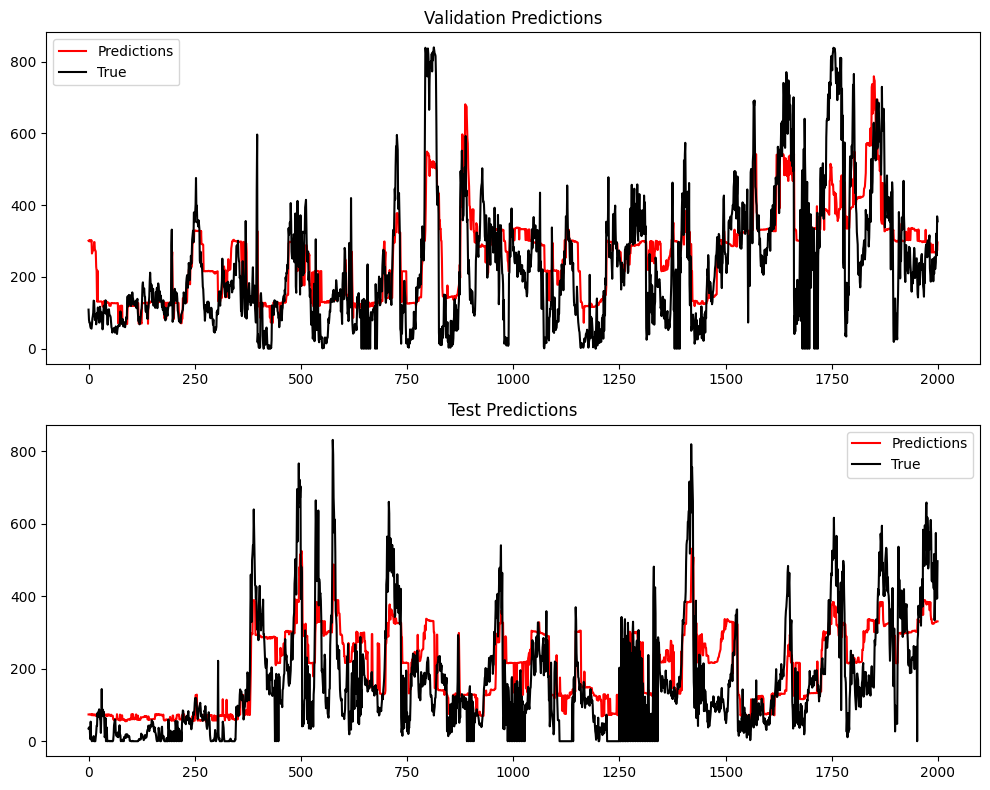

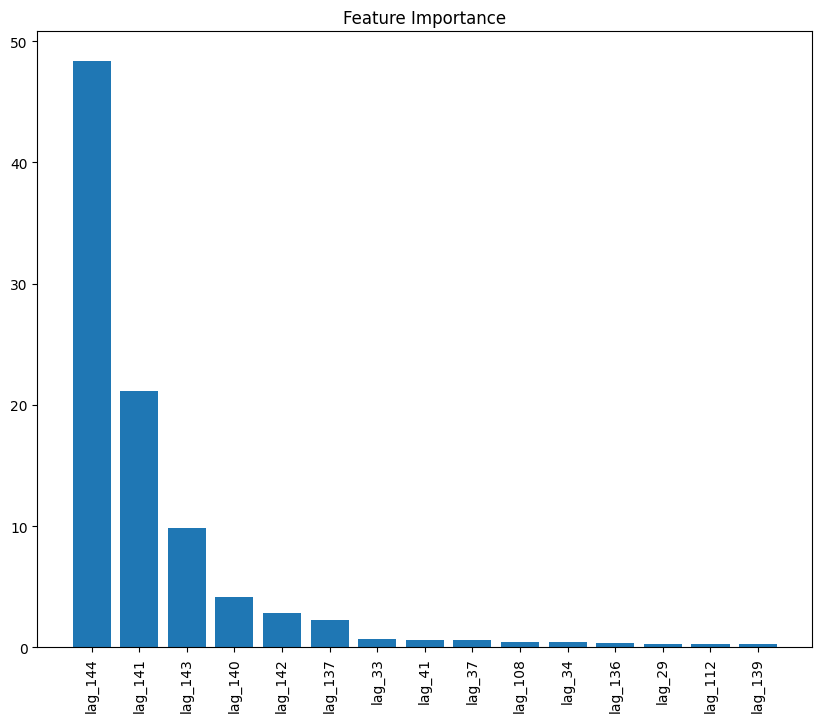

In [40]:
next_day_rec,_=model.model_summarizer(val_x, val_y[:,0], test_x, test_y[:,0], plots=True,
plot_steps=2000, feat_importance=True, feat_steps=15,feat_names= columns,horizon =144)

# Result Comparison

In [42]:
from tabulate import tabulate

results = [next_step_os.iloc[1,:],next_hour_os.iloc[1,:],next_day_os.iloc[1,:],
           next_hour_rec.iloc[1,:],next_day_rec.iloc[1,:]]

names = ['Next Step One Shot', 'Next Hour One Shot', 'Next Day One Shot',
         'Next Hour Recursive', 'Next Day Recursive']
metrics = ['MAE', 'RMSE', 'R2']

header = ['Metric'] + metrics
table_data = []

# Append MAE, RMSE, and R2 values for the test set

for i,n in enumerate(names):
  value = [n] + [results[i]['MAE']] + [results[i]['RMSE']]+ [results[i]['R2']]
  table_data.append(value)
table = tabulate(table_data, headers=header, tablefmt='pipe')

In [43]:
print(table)

| Metric              |       MAE |      RMSE |       R2 |
|:--------------------|----------:|----------:|---------:|
| Next Step One Shot  |   5.34246 |   8.19611 | 0.998466 |
| Next Hour One Shot  |  83.3092  | 113.499   | 0.705722 |
| Next Day One Shot   | 160.126   | 191.788   | 0.15222  |
| Next Hour Recursive |  66.9368  |  92.828   | 0.803198 |
| Next Day Recursive  | 125.653   | 160.812   | 0.411974 |
